# Logistic Regression with a Neural Network mindset (Week 4 version)

**Note**: I removed some of the instructions from last week to make this notebook shorter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [2]:
def load_dataset():
    with h5py.File('datasets/train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('datasets/test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

In [5]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T 
### END CODE HERE ###

In [6]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [7]:
# GRADED FUNCTION: sigmoid
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [8]:
# GRADED FUNCTION: initialize_with_zeros
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w, b = np.zeros((dim,1)), 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [9]:
# GRADED FUNCTION: propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(w.T @ X + b)
    cost = -(1/m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m) * X @ (A-Y).T
    db = (1/m) * np.sum(A-Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [10]:
# GRADED FUNCTION: optimize
# Edited to calculate and save the test set accuracy every 10 iterations
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False, X_test=None, Y_test=None, threshold:float=0.5):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    test_accuracies = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 10 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs, test_accuracies

In [11]:
# GRADED FUNCTION: predict
# Modified to return actual probabilities as well as predictions and accept a threshold parameter
def predict(w, b, X, threshold:float=0.5):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]

    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(w.T @ X + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 0 if A[0, i] <= threshold else 1
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction, A.flatten()

In [12]:
# GRADED FUNCTION: model
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False, threshold:float=0.5):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs, test_accuracies = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost, X_test=X_test, Y_test=Y_test, threshold=threshold)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters['w']
    b = parameters['b']

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test, y_prob_test = predict(w, b, X_test, threshold=threshold)
    Y_prediction_train, y_prob_train = predict(w, b, X_train, threshold=threshold)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         'test_accuracies': test_accuracies,
         'y_prob_test': y_prob_test,
         'y_prob_train': y_prob_train}
    
    return d

In [13]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.744940
Cost after iteration 20: 0.719249
Cost after iteration 30: 0.697336
Cost after iteration 40: 0.677814
Cost after iteration 50: 0.659925
Cost after iteration 60: 0.643248
Cost after iteration 70: 0.627521
Cost after iteration 80: 0.612568
Cost after iteration 90: 0.598262
Cost after iteration 100: 0.584508
Cost after iteration 110: 0.571235
Cost after iteration 120: 0.558386
Cost after iteration 130: 0.545915
Cost after iteration 140: 0.533788
Cost after iteration 150: 0.521976
Cost after iteration 160: 0.510454
Cost after iteration 170: 0.499204
Cost after iteration 180: 0.488211
Cost after iteration 190: 0.477462
Cost after iteration 200: 0.466949
Cost after iteration 210: 0.456665
Cost after iteration 220: 0.446607
Cost after iteration 230: 0.436777
Cost after iteration 240: 0.427181
Cost after iteration 250: 0.417832
Cost after iteration 260: 0.408750
Cost after iteration 270: 0.399969
Cost after iteration 280: 0.391

# Question 1: 
Plot the decrease in the cost function vs iteration count.

Note that I modified the function to save the training cost at every iteration of training. This is why the graph is noisy in early iterations.

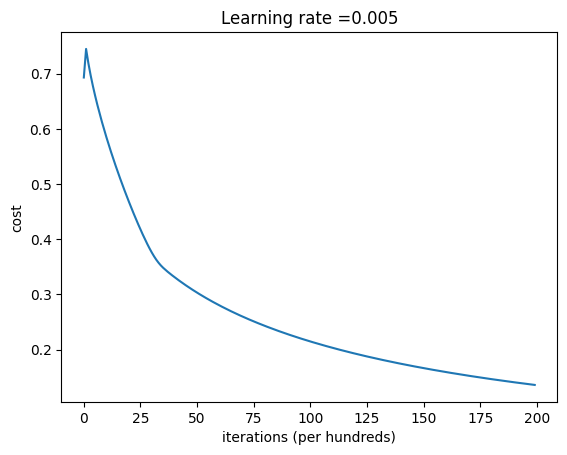

In [14]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

# Question 2
Play around with different initializations and report whether initializations influence the optimized training cost.

In [15]:
# function to initialize random weights
def initialize_with_random(dim, seed:int=1234):
    """
    This function creates a vector of random numbers of shape (dim, 1) for w and initializes b to a random number.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    np.random.seed(seed)
    w, b = np.random.uniform(low=1e-5, high=1e-3, size=(dim,1)), np.random.uniform(low=1e-5, high=1e-3)
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [16]:
# redefine model to accept a seed
def model_random_init(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False, seed:int=1234):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_random(X_train.shape[0], seed=seed)
    
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs, test_accuracies = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost, X_test=X_test, Y_test=Y_test)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters['w']
    b = parameters['b']

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test, y_prob_test = predict(w, b, X_test)
    Y_prediction_train, y_prob_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "seed": seed,
         'test_accuracies': test_accuracies}
    
    return d

In [17]:
# Test a range of seed values and store the resulting cost history
costs = {
}

for s in range(0, 250000, 10000):
    d = model_random_init(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 100, learning_rate = 0.001, print_cost = False, seed=s)
    costs[f'seed {s}'] = d['costs']

train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy: 66.98564593301435 %
test accuracy: 36.0 %
train accuracy: 66.50717703349282 %
test accuracy: 36.0 %
train accuracy

Text(0.5, 1.0, 'Cost vs Iterations for Different Random Initializations')

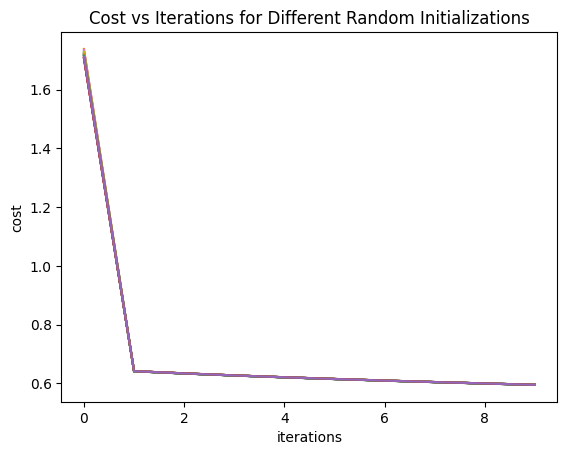

In [18]:
# Plot learning curves for different seeds
for key in costs:
    plt.plot(np.squeeze(costs[key]), label=key)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title('Cost vs Iterations for Different Random Initializations')

<Axes: title={'center': 'Standard Deviation of Cost vs Iterations'}, xlabel='Iterations', ylabel='Standard Deviation of Cost'>

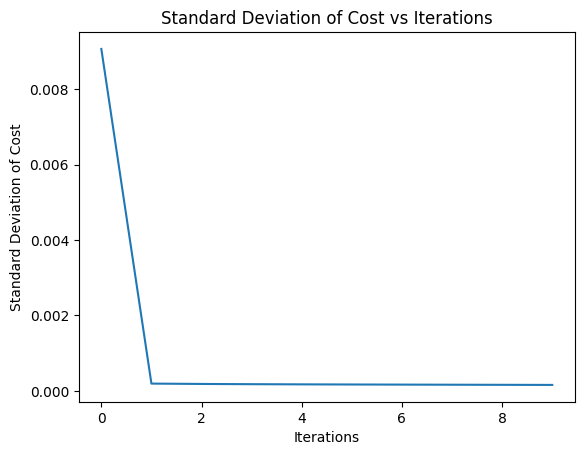

In [19]:
df=pd.DataFrame(costs)
df.transpose().agg('std').plot(
    title='Standard Deviation of Cost vs Iterations',
    ylabel='Standard Deviation of Cost',
    xlabel='Iterations'
)

As we can see, changing the initialization values does affect cost for the first few iterations, but after only 10 iterations there is basically no variation.

It's important to note that choosing larger initialization values led to instability and failure to converge. I found that if I changed my sampling distribution from Uniform(1e-5, 1e-3) to Uniform(1e-5, 1e-2), then some models would fail. This is because the sigmoid function has flat derivatives when evaluated at large values. Since there are >12,000 weights, we need each weight to be small so that the sigmoid function evaluates on a non-flat region.

# Question 3: 
Compute the confusion matrix and then evaluate the precision, recall, and False Positive Rate of your trained algorithm.

In [20]:
# Rerunning with more iterations
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 10000, learning_rate = 0.005, print_cost = False)

train accuracy: 100.0 %
test accuracy: 70.0 %


In [21]:
def make_confusion_matrix(y_actual, y_predicted):
    df_confusion = pd.DataFrame({'y_actual': y_actual.flatten(), 'y_predicted': y_predicted.flatten()})
    df_confusion['y_predicted'] = df_confusion['y_predicted'].astype(int)

    TP = len(df_confusion[(df_confusion['y_actual'] == 1) & (df_confusion['y_predicted'] == 1)])
    TN = len(df_confusion[(df_confusion['y_actual'] == 0) & (df_confusion['y_predicted'] == 0)])
    FP = len(df_confusion[(df_confusion['y_actual'] == 0) & (df_confusion['y_predicted'] == 1)])
    FN = len(df_confusion[(df_confusion['y_actual'] == 1) & (df_confusion['y_predicted'] == 0)])

    precision = TP / (TP + FP) * 100
    recall = TP / (TP + FN) * 100
    fpr = FP / (FP + TN) * 100

    print(f'        Predicted   +       -')
    print(f'Actual +            {TP}     {FN}')
    print(f'Actual -            {FP}      {TN}\n')

    print(f'Precision: {precision:.01f}%')
    print(f'Recall: {recall:.01f}%')
    print(f'False Positive Rate: {fpr:.01f}%')

    return precision, recall, fpr

make_confusion_matrix(test_set_y, d['Y_prediction_test'])

        Predicted   +       -
Actual +            23     10
Actual -            5      12

Precision: 82.1%
Recall: 69.7%
False Positive Rate: 29.4%


(82.14285714285714, 69.6969696969697, 29.411764705882355)

# Question 4
 Split your datasets in different ratios (80:20, 50:50, 20:80) and report the metrics in 1. Comment on whether the split ratio makes a difference to model performance.

In [22]:
# Combine the train and test sets so that we can split them in different ratios
full_set_x = np.hstack((train_set_x, test_set_x))
full_set_y = np.hstack((train_set_y, test_set_y))

In [23]:
# Function to split the data into training and test sets based on a given ratio
def train_ratio(X, y, train_ratio=80):
    np.random.seed(1234)
    train_indices = np.random.choice(X.shape[1], size=int(X.shape[1]*train_ratio/100), replace=False)
    test_indices = np.array([i for i in range(X.shape[1]) if i not in train_indices])
    return X[:, train_indices], y[:, train_indices], X[:, test_indices], y[:, test_indices]

# Test a range of ratios values and store the resulting cost history
costs = {
}

for ratio in range(10, 100, 10):
    x_train, y_train, x_test, y_test = train_ratio(full_set_x, full_set_y, train_ratio=ratio)
    d = model(x_train, y_train, x_test, y_test, num_iterations = 1000, learning_rate = 0.005, print_cost = False)
    costs[f'ratio {ratio}'] = d['costs']

train accuracy: 100.0 %
test accuracy: 57.69230769230769 %
train accuracy: 100.0 %
test accuracy: 52.88461538461539 %
train accuracy: 100.0 %
test accuracy: 54.395604395604394 %
train accuracy: 100.0 %
test accuracy: 55.769230769230774 %
train accuracy: 100.0 %
test accuracy: 57.69230769230769 %
train accuracy: 99.35483870967742 %
test accuracy: 58.65384615384615 %
train accuracy: 98.34254143646409 %
test accuracy: 64.1025641025641 %
train accuracy: 97.10144927536231 %
test accuracy: 71.15384615384616 %
train accuracy: 96.13733905579399 %
test accuracy: 80.76923076923077 %


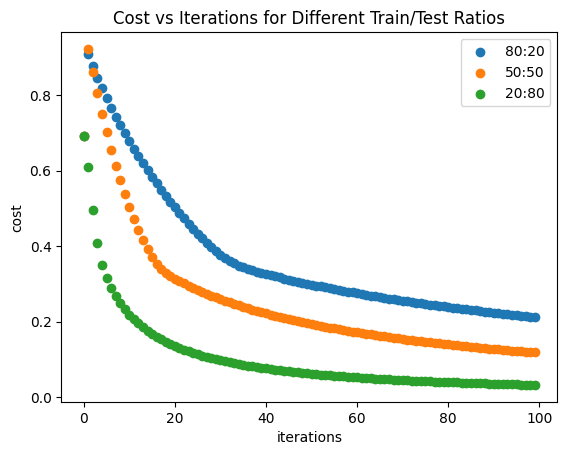

In [24]:
# Plot learning curves for different ratios
plt.scatter(range(len(costs['ratio 80'])), costs['ratio 80'], label='80:20')
plt.scatter(range(len(costs['ratio 50'])), costs['ratio 50'], label='50:50')
plt.scatter(range(len(costs['ratio 20'])), costs['ratio 20'], label='20:80')

plt.ylabel('cost')
plt.xlabel('iterations')
plt.title('Cost vs Iterations for Different Train/Test Ratios')
plt.legend()
plt.show()

Looking at the graph, we see that a larger training ratio has a slower gradient descent on the training data compared to a smaller training ratio. However, looking at the accuracy results shows that there is a tradeoff between training and testing accuracy as well: smaller training ratios have better training accuracy but worse testing accuracy. Larger training ratios have better testing accuracy. This is likely because wth a larger training dataset, the model gets more examples to learn the underlying patterns in the data.

# Question 5:
For the 80:20 split case, evaluate the performance metrics in 3 and also ROC as you vary the probability threshold.

Note: I modified the predict function above to accept a classification threshold. 

In [25]:
ratio = 80
x_train, y_train, x_test, y_test = train_ratio(full_set_x, full_set_y, train_ratio=ratio)
print(f'Train ratio: {ratio}\n')

results = {
    'thresholds': [],
    'precisions': [],
    'recalls': [],
    'fprs': []
}

for threshold in range(1, 10):
    print(f'\nClassification Threshold: {threshold/10}\n')
    d = model(x_train, y_train, x_test, y_test, num_iterations = 1000, learning_rate = 0.01, print_cost = False, threshold=threshold/10)
    precision, recall, fpr = make_confusion_matrix(y_test, d['Y_prediction_test'])
    results['thresholds'].append(threshold/10)
    results['precisions'].append(precision)
    results['recalls'].append(recall)
    results['fprs'].append(fpr)

Train ratio: 80


Classification Threshold: 0.1

train accuracy: 83.57487922705315 %
test accuracy: 63.46153846153847 %
        Predicted   +       -
Actual +            19     1
Actual -            18      14

Precision: 51.4%
Recall: 95.0%
False Positive Rate: 56.2%

Classification Threshold: 0.2

train accuracy: 92.7536231884058 %
test accuracy: 69.23076923076923 %
        Predicted   +       -
Actual +            18     2
Actual -            14      18

Precision: 56.2%
Recall: 90.0%
False Positive Rate: 43.8%

Classification Threshold: 0.3

train accuracy: 97.58454106280193 %
test accuracy: 69.23076923076923 %
        Predicted   +       -
Actual +            17     3
Actual -            13      19

Precision: 56.7%
Recall: 85.0%
False Positive Rate: 40.6%

Classification Threshold: 0.4

train accuracy: 99.03381642512078 %
test accuracy: 71.15384615384616 %
        Predicted   +       -
Actual +            15     5
Actual -            10      22

Precision: 60.0%
Recall: 75.0%
Fal

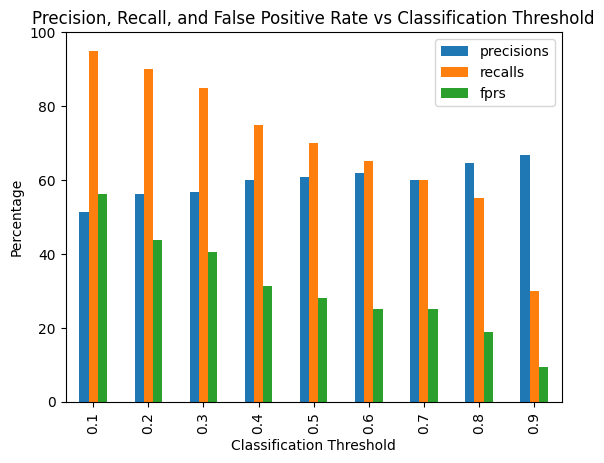

In [26]:
# Barchart of precision, recall, and false positive rate for different classification thresholds
df_results = pd.DataFrame(results)
df_results.set_index('thresholds').plot.bar(
    title='Precision, Recall, and False Positive Rate vs Classification Threshold',
    ylabel='Percentage',
    xlabel='Classification Threshold',
    ylim=(0, 100)
)
plt.show()

Note: to get the actual ROC curve, I modified functions above to return the model's predicted probabilities, not just the 0-1 predictions.

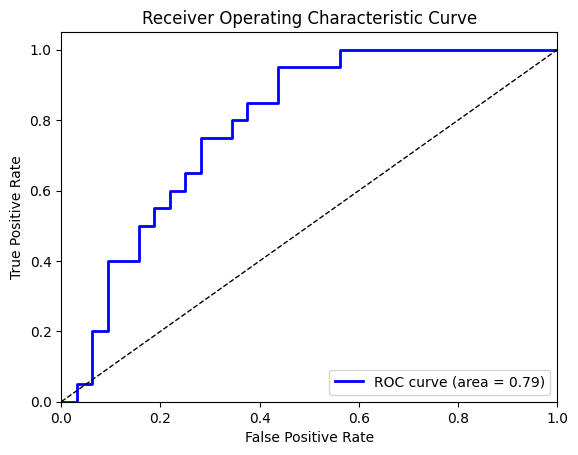

In [27]:
# Plot the ROC curve and report AUC
fpr, tpr, thresholds = roc_curve(y_test.flatten(), d['y_prob_test'].flatten())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

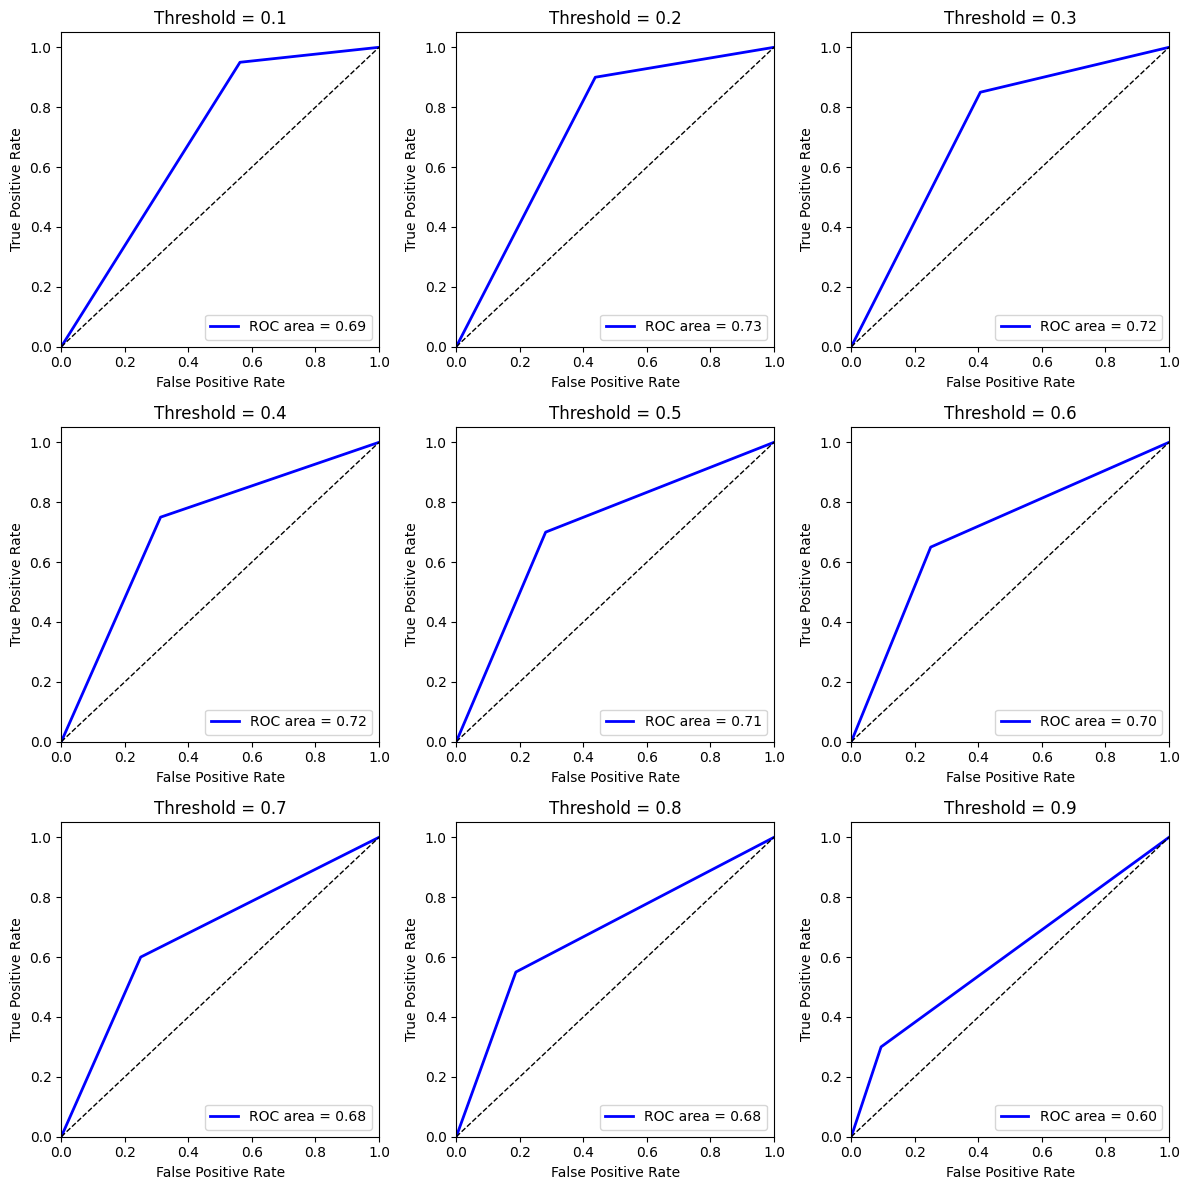

In [28]:
# Since we have the actual probabilities, we can test arbitrary thresholds for ROC curves
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx, threshold in enumerate(range(1, 10)):
    predicts = np.where(d['y_prob_test'] <= threshold/10, 0, 1)
    fpr, tpr, _ = roc_curve(y_test.flatten(), predicts)
    roc_auc = auc(fpr, tpr)
    ax = axes[idx]
    ax.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Threshold = {threshold/10}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Question 6:
Visualize 3 examples of True-Positives, True-Negatives, False-Positives, and False-Negatives.

In [29]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 10000, learning_rate = 0.005, print_cost = False)

train accuracy: 100.0 %
test accuracy: 70.0 %


In [30]:
# Identify the indexes of all TP, FP, TN, FN
y_actual = test_set_y.flatten()
y_predicted = d['Y_prediction_test'].flatten()

TP_indexes = np.where((y_actual == 1) & (y_predicted == 1))[0]
FP_indexes = np.where((y_actual == 0) & (y_predicted == 1))[0]
TN_indexes = np.where((y_actual == 0) & (y_predicted == 0))[0]
FN_indexes = np.where((y_actual == 1) & (y_predicted == 0))[0]

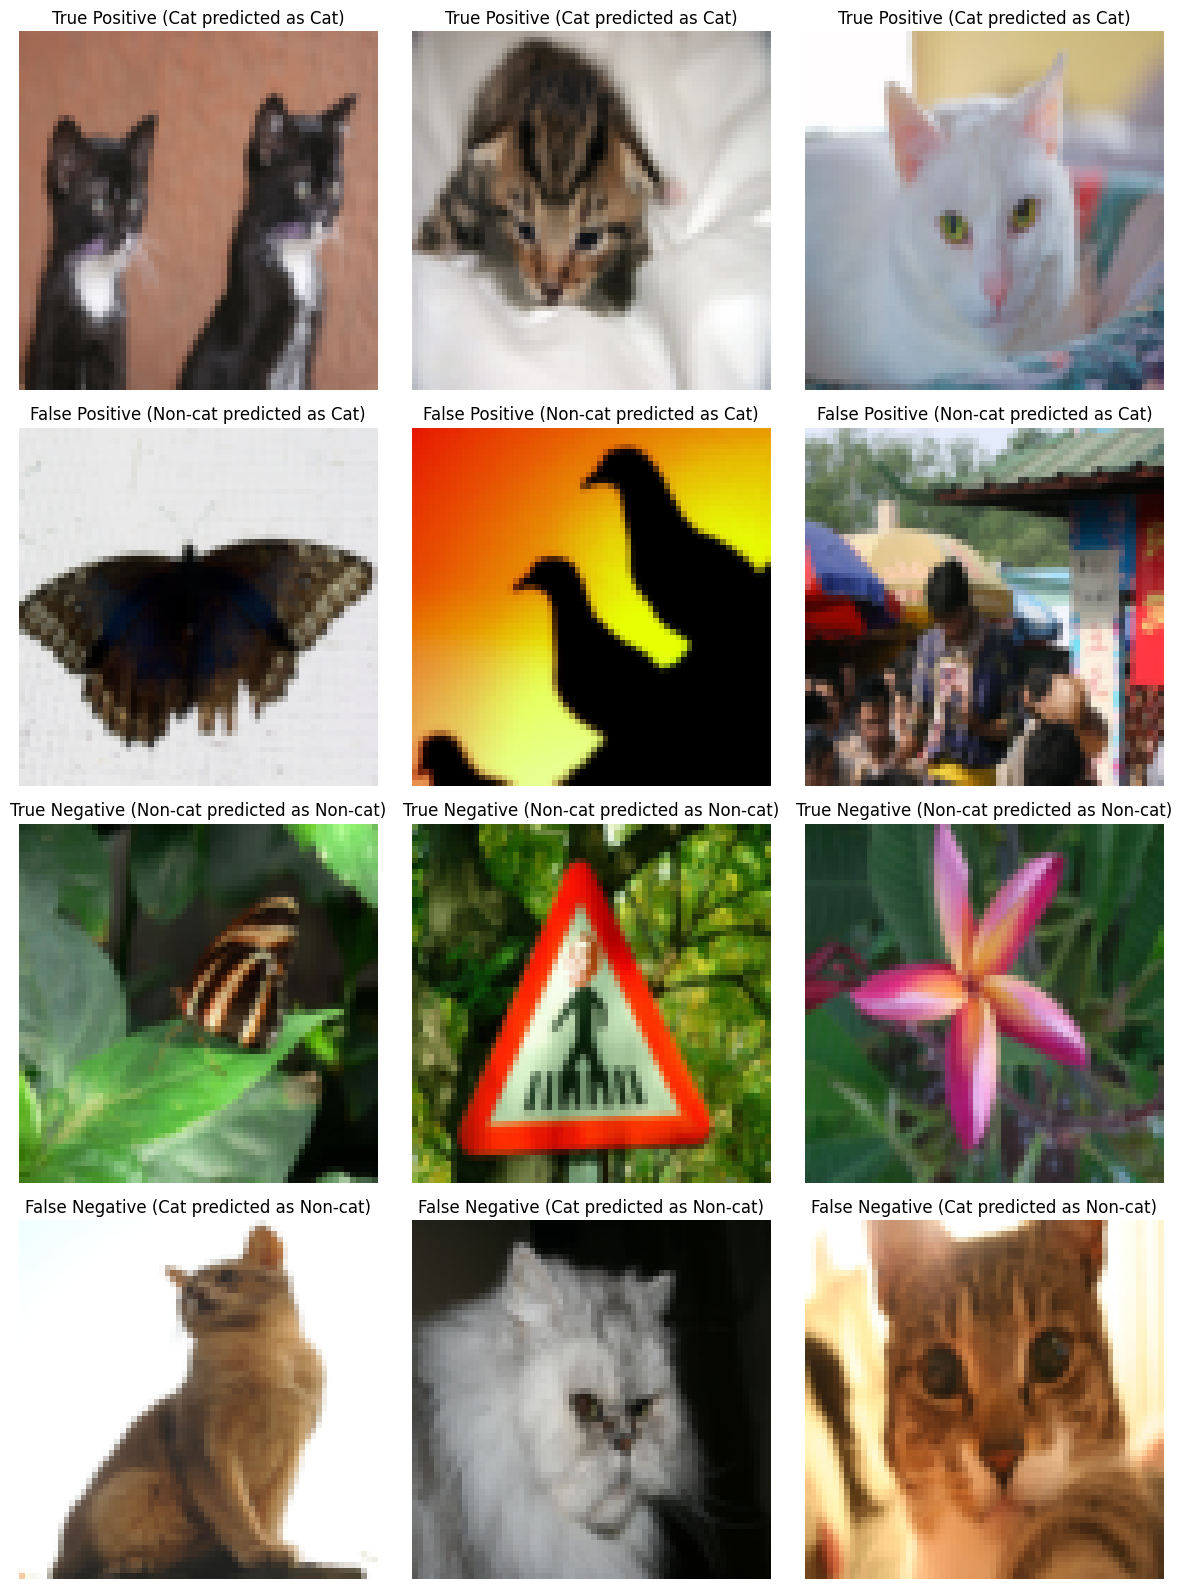

In [31]:
# Create a 4x3 subplot for TP, FP, TN, FN examples
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

# Define the categories and their corresponding indexes
categories = [
    ('True Positive (Cat predicted as Cat)', TP_indexes),
    ('False Positive (Non-cat predicted as Cat)', FP_indexes),
    ('True Negative (Non-cat predicted as Non-cat)', TN_indexes),
    ('False Negative (Cat predicted as Non-cat)', FN_indexes)
]

# Plot 3 examples for each category
for row, (title, indexes) in enumerate(categories):
    for col in range(3):
        # Reshape and display the image
        img = test_set_x[:, indexes[col]].reshape((num_px, num_px, 3))
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{title}')
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()